In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt 
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import sklearn.metrics as metrics

In [22]:
df_train = pd.read_csv('train.csv', sep="," , encoding = "UTF8" )
df_test2 = pd.read_csv('test.csv', sep="," , encoding = "UTF8" )

In [23]:
df_train1 = pd.read_csv('train.csv', sep="," , encoding="UTF8", usecols = [
    'NU_NOTA_MT',   
    'NU_NOTA_CN',
    'NU_NOTA_CH',
    'NU_NOTA_LC',
    'NU_NOTA_REDACAO',
    'NU_NOTA_COMP1',
    'NU_NOTA_COMP2',
    'NU_NOTA_COMP3',
    'NU_NOTA_COMP4',
    'NU_NOTA_COMP5',
    'NU_IDADE',
    'TP_COR_RACA',
    'TP_ESCOLA'] )

In [24]:
df_test1 = pd.read_csv('test.csv', sep="," , encoding="UTF8" , usecols = [
    'NU_NOTA_CN',
    'NU_NOTA_CH',
    'NU_NOTA_LC',
    'NU_NOTA_REDACAO',
    'NU_NOTA_COMP1',
    'NU_NOTA_COMP2',
    'NU_NOTA_COMP3',
    'NU_NOTA_COMP4',
    'NU_NOTA_COMP5',
    'NU_IDADE',
    'TP_COR_RACA',
    'TP_ESCOLA'])

In [25]:
# verifica o que foi importado
df_train1.head()
df_test1.head()

,NU_IDADE,TP_COR_RACA,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
0,22,3,1,464.8,443.5,431.8,120.0,80.0,80.0,100.0,40.0,420.0
1,26,3,1,391.1,491.1,548.0,120.0,120.0,120.0,120.0,100.0,580.0
2,21,1,2,595.9,622.7,613.6,80.0,40.0,40.0,80.0,80.0,320.0
3,27,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18,1,2,592.9,492.6,571.4,100.0,80.0,60.0,80.0,0.0,320.0


In [26]:
# vendo max, min, mean e etc!
calculo = df_train1.describe()
calculo

,NU_IDADE,TP_COR_RACA,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
count,13730.000000,13730.000000,13730.000000,10341.000000,10341.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000
mean,21.593809,2.185652,1.353532,473.495155,529.661087,516.472841,482.497928,119.811704,111.915918,106.824238,113.123951,77.372446,529.048258
std,7.043654,1.007285,0.558472,71.093674,73.726344,68.688190,99.826323,29.846017,33.737588,34.341349,33.480033,43.067140,154.294758
min,13.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.000000,1.000000,419.900000,480.400000,468.100000,408.900000,120.000000,100.000000,80.000000,100.000000,40.000000,440.000000
50%,19.000000,3.000000,1.000000,459.800000,532.000000,520.900000,461.200000,120.000000,120.000000,120.000000,120.000000,80.000000,540.000000
75%,23.000000,3.000000,2.000000,514.500000,581.200000,564.900000,537.600000,140.000000,120.000000,120.000000,120.000000,100.000000,600.000000
max,67.000000,5.000000,4.000000,806.400000,807.000000,763.600000,952.000000,200.000000,200.000000,200.000000,200.000000,200.000000,1000.000000


In [27]:
# Irei filtrar features de correlações para ver se o modelo vai ficar legal
melhores = df_train1.corr()
features = melhores[(melhores['NU_NOTA_MT'] <= 0.1) | (melhores['NU_NOTA_MT'] >= 0.1)
        & (melhores['NU_NOTA_MT'] < 1.0)]['NU_NOTA_MT']
features

NU_IDADE          -0.061485
TP_COR_RACA       -0.157364
TP_ESCOLA          0.069304
NU_NOTA_CN         0.584941
NU_NOTA_CH         0.529594
NU_NOTA_LC         0.494695
NU_NOTA_COMP1      0.299402
NU_NOTA_COMP2      0.335638
NU_NOTA_COMP3      0.350307
NU_NOTA_COMP4      0.342282
NU_NOTA_COMP5      0.343337
NU_NOTA_REDACAO    0.379376
Name: NU_NOTA_MT, dtype: float64

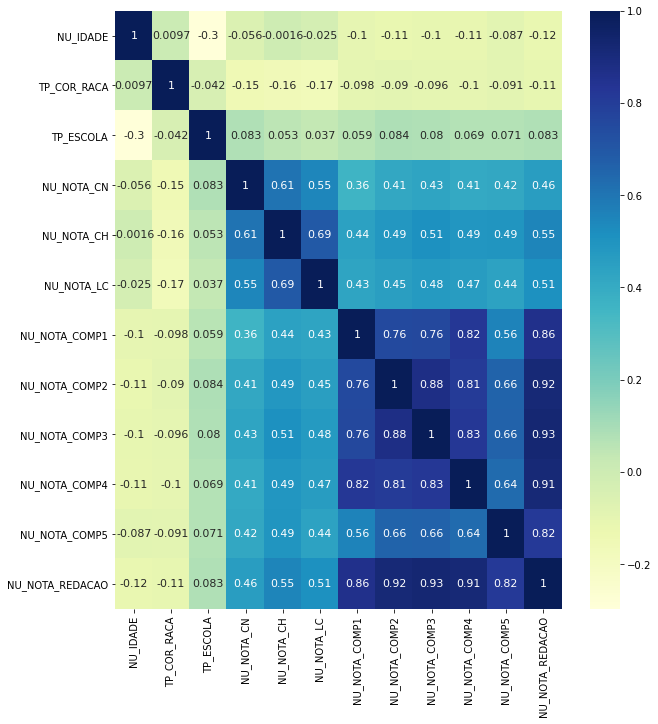

In [28]:
# grafico que vai desmonstrar a relacao das colunas
features_list = features.index.to_list()
corr = df_train1[features_list].corr()
ax = plt.subplots(figsize=(10, 11))
sns.heatmap(corr,  annot=True, annot_kws={"size": 11},cmap="YlGnBu")

In [29]:
#contagem dos nao nulos
df_train1.count()

NU_IDADE           13730
TP_COR_RACA        13730
TP_ESCOLA          13730
NU_NOTA_CN         10341
NU_NOTA_CH         10341
NU_NOTA_LC         10133
NU_NOTA_MT         10133
NU_NOTA_COMP1      10133
NU_NOTA_COMP2      10133
NU_NOTA_COMP3      10133
NU_NOTA_COMP4      10133
NU_NOTA_COMP5      10133
NU_NOTA_REDACAO    10133
dtype: int64

In [30]:
# excluindo valores null's, mas nesse caso vou utilizar as medias e fazer a atribuição
# nas linhas que estão com NAN
df_train1 = df_train1.loc[(df_train1['NU_NOTA_CN'].notnull())]

In [31]:
# contagem dos nao nulos
df_test1.count()

NU_IDADE           4576
TP_COR_RACA        4576
TP_ESCOLA          4576
NU_NOTA_CN         3442
NU_NOTA_CH         3442
NU_NOTA_LC         3377
NU_NOTA_COMP1      3377
NU_NOTA_COMP2      3377
NU_NOTA_COMP3      3377
NU_NOTA_COMP4      3377
NU_NOTA_COMP5      3377
NU_NOTA_REDACAO    3377
dtype: int64

In [32]:
 #calculando a media fazendo de dois jeitos 
 #1) 
df_train1['NU_NOTA_CN'].fillna(df_train1['NU_NOTA_CN'].mean(), inplace=True)
df_test1['NU_NOTA_CN'].fillna(df_test1['NU_NOTA_CN'].mean(), inplace=True)


In [33]:
features_list.append('NU_NOTA_MT')

In [34]:
#2 bom sem duvidas esse é a melhor opcao até mesmo porque se focemos 
# aderir a primeira iriamos fazer uma a uma e isso levaria tempo 
df1_train = df_train1.copy()
df1_test = df_test1.copy()

def zerandoColunas(data):
    for item in features_list:
        data[item] = data[item].fillna(0)
    return data
df1_train = zerandoColunas(df1_train)
df1_test = df1_test.fillna(0)


In [35]:
# Agora vamos atribuir as medias das colunas
df2_train = df_train1.copy()
df2_test = df_test1.copy()

def mediaColunas(data):
    for item in features_list:
        data[item] = data[item].fillna(data[item].mean())
    return data

df2_train = mediaColunas(df2_train)
df2_test = df1_test.fillna(df2_test.mean())

In [36]:
# Criando dataset de respostas
df_result = pd.DataFrame()

In [37]:
# Adicionando número de inscrição a ser salvo no arquivo de resposta final
df_result['NU_INSCRICAO'] = df_test2['NU_INSCRICAO']

In [38]:
# Removendo a variável target
features_list.remove('NU_NOTA_MT')

In [39]:
x_train = df1_train[features_list]
y_train = df1_train['NU_NOTA_MT']
x_test = df1_test[features_list]

In [40]:
pipe_RFR = Pipeline([('scaler',  StandardScaler()),
            ('RandomForestRegressor', RandomForestRegressor())])

In [41]:
CV_pipe_RFR = RandomizedSearchCV(estimator = pipe_RFR, param_distributions = {},
                                 cv = 5,return_train_score=True, verbose=0)

In [42]:
CV_pipe_RFR.fit(x_train, y_train)

C:\Users\rogerio\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('RandomForestRegressor',
                                              RandomForestRegressor())]),
                   param_distributions={}, return_train_score=True)

In [43]:
ypred2 = CV_pipe_RFR.predict(x_test)

In [44]:
df_result['NU_NOTA_MT'] = np.around(ypred2,2)

In [45]:
df_result.to_csv('answer10.csv', index=False, header=True)